# Import libraries

In [16]:
import pandas as pd
import numpy as np
import os

from helper_functions import smape_comp
from configs import (
    TRAIN_PATH,
    CENSUS_STARTER_PATH,
    OUTPUT_PATH,
    TEST_PATH,
    REVEALED_TEST_PATH,
    SAMPLE_SUBMISSION_PATH,
    CENSUS_2020_PATH,
    CENSUS_2021_PATH,
)


# Load data

In [2]:
census_starter = pd.read_csv(CENSUS_STARTER_PATH)
revealed_test = pd.read_csv(REVEALED_TEST_PATH)
sample_submission = pd.read_csv(SAMPLE_SUBMISSION_PATH)
test = pd.read_csv(TEST_PATH)
train = pd.read_csv(TRAIN_PATH, parse_dates=["first_day_of_month"])

census_2020 = pd.read_csv(CENSUS_2020_PATH)
census_2020 = census_2020.iloc[1:]

census_2021 = pd.read_csv(CENSUS_2021_PATH)
census_2021 = census_2021.iloc[1:]


c:\Users\apuengpreeda\miniconda3\envs\myenv\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (2,5,6,7,10,11,12,13,14,15,16,17,18,19,22,23,26,29,30,33,34,35,36,37,38,39,40,41,42,43,46,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,82,83,86,87,90,91,94,97,98,99,100,101,102,103,106,107,108,109,110,111,112,113,114,115,116,117,118,121,122,125,126,127,128,129,130,131,134,135,138,139,142,143,158,159,162,163,164,165,166,167,168,169,170,171,174,177,178,181,182,185,186,187,188,189,190,191,192,193,194,197,198,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,234,235,238,239,242,245,246,249,250,251,252,253,254,257,258,259,260,261,262,263,264,265,266,267,268,269,270,273,274,275,298,301,302,303,306,307,310,311,314,315,316,317,318,319,320,321,322,325,326,329,330,331,334,335,338,339,340,341,342,343,344,345,346,349,350,351,354,355,356,357,358,359,360,361,

# Baseline model on train data

In [4]:
df_train = train[train['first_day_of_month']<='2022-07-01']
df_valid = train[train['first_day_of_month']>='2022-08-01']

In [5]:
last_known_y_train = df_train.drop_duplicates(['cfips'], keep='last')
last_known_y_train = last_known_y_train[['cfips', 'microbusiness_density']].reset_index(drop=True)
last_known_y_train = last_known_y_train.rename(columns={'microbusiness_density': 'y_pred'})

In [6]:
df_baseline = pd.merge(df_valid, last_known_y_train, on=['cfips'], how='left')

In [7]:
smape_comp(df_baseline['microbusiness_density'], df_baseline['y_pred'])

1.8729511099278124

27151


<AxesSubplot:xlabel='first_day_of_month'>

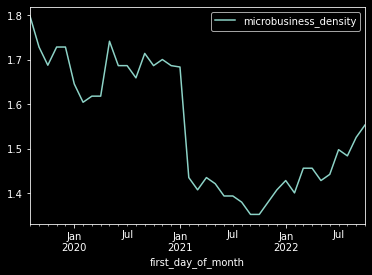

In [8]:
rand_cfips = np.random.choice(train['cfips'])
print(rand_cfips)
train[train['cfips']==rand_cfips].plot(x='first_day_of_month', y='microbusiness_density')

# Prepare submission from last known data

In [9]:
census_2020['cfips'] = census_2020['GEO_ID'].apply(lambda x: x.split('US')[1]).astype(int)
census_2020['adult_pop'] = census_2020['S0101_C01_026E'].astype(int)

adult_2020 = census_2020[['cfips', 'adult_pop']]


census_2021['cfips'] = census_2021['GEO_ID'].apply(lambda x: x.split('US')[1]).astype(int)
census_2021['adult_pop'] = census_2021['S0101_C01_026E'].astype(int)

adult_2021 = census_2021[['cfips', 'adult_pop']]

adult_trends = pd.merge(adult_2020, adult_2021, on=['cfips'], how='left', suffixes=['_2020', '_2021'])

In [10]:
last_known_y = revealed_test.drop_duplicates(['cfips'], keep='last')
last_known_y = last_known_y[['cfips', 'microbusiness_density']].reset_index(drop=True)
last_known_y = last_known_y.rename(columns={'microbusiness_density': 'y_pred'})

In [11]:
sample_submission['cfips'] = sample_submission['row_id'].apply(lambda x: x.split("_")[0]).astype(int)

In [12]:
submission = pd.merge(sample_submission, last_known_y, on=['cfips'], how='left')

submission = pd.merge(submission, adult_trends, on=['cfips'], how='left')
submission['adjusted_y_pred'] = submission['y_pred'] / (submission['adult_pop_2021'] / submission['adult_pop_2020'])

In [13]:
submission['microbusiness_density'] = submission['adjusted_y_pred']
submission = submission[['row_id', 'microbusiness_density']]

In [22]:
submission.to_csv(os.path.join(OUTPUT_PATH, "submission.csv"), index=False)